##GUIA 06 CONSTRUIR GRAFO DE BRUJIN

In [6]:
%pip install networkx

Note: you may need to restart the kernel to use updated packages.


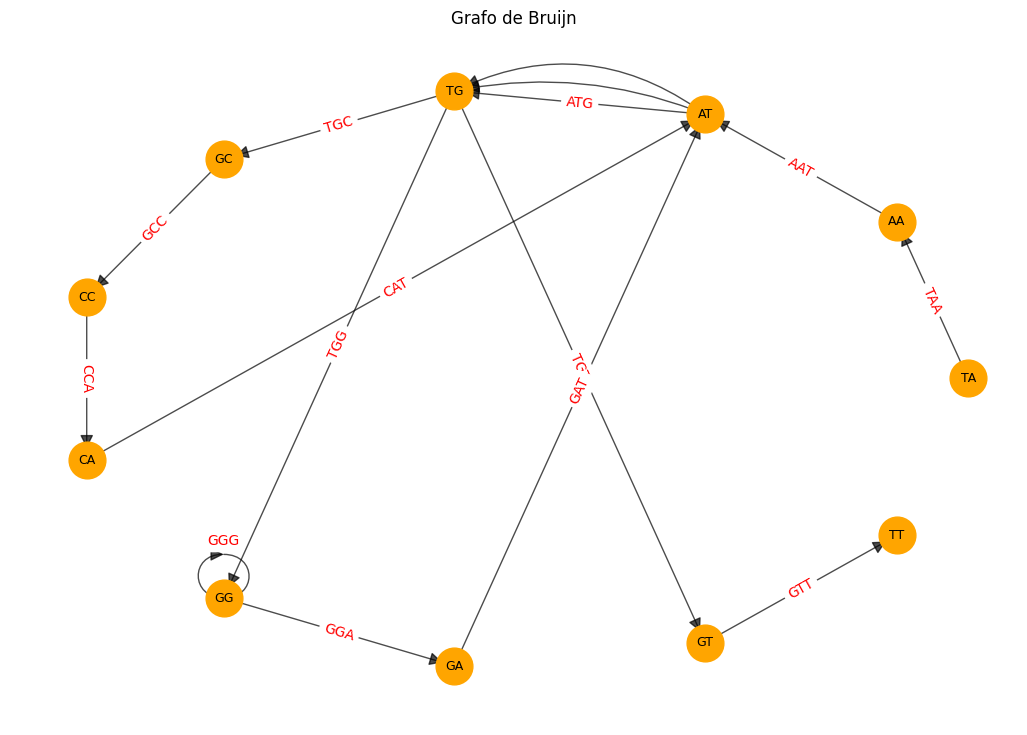

Camino Euleriano: ['TA', 'AA', 'AT', 'TG', 'GC', 'CC', 'CA', 'AT', 'TG', 'GG', 'GG', 'GA', 'AT', 'TG', 'GT', 'TT']


In [52]:
import networkx as nx
import matplotlib.pyplot as plt

class BruijnGrafo:
    def __init__(self, input_data, k, is_kmers=False):
        """---------------------------------------------------------------------
        Constructor de la clase BruijnGraph.

        Parameters:
        input_data: Secuencia de ADN (str) o lista de k-mers (list of str).
        k         : Int, la longitud de los k-mers.
        is_kmers  : Booleano, si es True, input_data es una lista de k-mers, si
                    es False es una secuencia de ADN.
        ----------------------------------------------------------------------"""
        self.k = k
        if is_kmers:
            # -- Si se proporciona una lista de k-mers
            self.kmers = input_data
        else:
            # -- Si se proporciona una secuencia, dividirla en k-mers
            self.kmers = self._sequence_to_kmers(input_data)

        # -- Construir el grafo de Bruijn
        self.graph = self.build_bruijn_graph()

    def _sequence_to_kmers(self, sequence):
        """---------------------------------------------------------------------
        Convierte una secuencia de ADN en una lista de k-mers.

        Parameters:
        sequence: Secuencia de ADN (str)

        Returns:
        List of k-mers (list of str).
        ---------------------------------------------------------------------"""
        kmers = [sequence[i:i + self.k] for i in range(len(sequence) - self.k + 1)]
        return kmers

    def build_bruijn_graph(self):
        """---------------------------------------------------------------------
        Construye un grafo de Bruijn a partir de la lista de k-mers.

        Returns:
        G: Grafo de Bruijn como un objeto NetworkX.
        ---------------------------------------------------------------------"""
        G = nx.MultiDiGraph()          # -- Multigrafo dirigido

        # -- Itera sobre cada k-mer
        for kmer in self.kmers:
            prefix = kmer[:-1]    # -- Sufijo (primeras k-1 bases)
            suffix = kmer[1:]     # -- Prefijo (últimas k-1 bases)

            # -- Si el prefijo ya existe, agrega el arco (o aumenta el contador si ya existe)
            if G.has_edge(prefix, suffix):
                # -- Si ya existe, obtener la última clave (key) de la arista y acceder a su 'weight'
                last_key = list(G[prefix][suffix].keys())[-1]
                new_weight = G[prefix][suffix][last_key]['weight'] + 1
                # -- Incrementar el 'weight'
                G.add_edge(prefix, suffix, weight=new_weight)
            else:
                # -- Si el prefijo no tiene aristas, añade una nueva
                G.add_edge(prefix, suffix, weight=0)  # -- Agrega el arco entre prefijo y sufijo
        edges = G.edges(data=True, keys=True)

        return G

    def draw_graph(self, layout='circular'):
        """---------------------------------------------------------------------
        Dibuja el grafo de Bruijn en el layout especificado.

        Parameters:
        layout: El tipo de layout para el grafo ('spring' o 'circular').
        ---------------------------------------------------------------------"""
        if layout == 'spring':
            # -- Layout de los nodos en 2D (disposición por "spring")
            pos = nx.spring_layout(self.graph)
        elif layout == 'circular':
            # -- Layout circular para una visualización más clara
            pos = nx.circular_layout(self.graph)
        else:
            raise ValueError("Layout no soportado. Usa 'spring' o 'circular'.")

        # -- Define el tamaño de la figura
        plt.figure(figsize=(13, 9))

        # -- Dibuja los nodos
        nx.draw_networkx_nodes(self.graph, pos, node_size=700, node_color='orange')

        # -- Dibuja las etiquetas de los nodos (k-mers)
        nx.draw_networkx_labels(self.graph, pos, font_size=9, font_color='black')

        # -- Dibuja los arcos (manejo de arcos paralelos)
        # -- Iteramos sobre las aristas y dibujamos los arcos paralelos manualmente
        for (node1, node2, data) in self.graph.edges(data=True):
            # -- Obtener el k-mer asociado a la arista
            kmer = node1 + node2[-1]  # -- El k-mer es la concatenación de la parte final del nodo2 con node1

            # -- Recuperar el peso (si está presente)
            weight = data.get('weight', 0)  # -- Valor por defecto si no hay peso especificado

            # -- Configurar color, tamaño y desplazamiento de las aristas
            offset = 0.15 * weight  # -- Desplazamiento según el peso
            color = 'black'

            # -- Dibujar las aristas, permitiendo desplazamiento para arcos paralelos
            nx.draw_networkx_edges(
                self.graph, pos,
                edgelist=[(node1, node2)],
                edge_color=color,
                arrowstyle='-|>', arrowsize=20,
                width=1, alpha=0.7,
                connectionstyle=f"arc3,rad={offset}"  # -- Desplazamiento radial para arcos paralelos
            )

        # -- Dibuja las etiquetas de los k-mers sobre las aristas
        edge_labels = {}
        for (prefix, suffix, data) in self.graph.edges(data=True):
            # Extrae el k-mer asociado a la arista (usamos el prefijo y sufijo para determinar el k-mer)
            kmer = prefix + suffix[-1]  # La parte final del sufijo corresponde al último carácter del k-mer
            edge_labels[(prefix, suffix)] = kmer

        # -- Dibuja las etiquetas de los k-mers sobre las aristas
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_color='red', font_size=10)

        plt.title('Grafo de Bruijn')
        plt.axis('off') # -- Desactiva los ejes
        plt.show()

    def find_eulerian_path(self):
        """---------------------------------------------------------------------
        Encuentra un camino o ciclo Euleriano en el grafo de Bruijn usando el
        Algoritmo de Hierholzer.

        Returns:
        path: Listado de nodos en el orden del camino/ciclo euleriano.
        ---------------------------------------------------------------------"""
        G = self.graph.copy()  # Copia del grafo original para no modificarlo

        # -- Verificar que el grafo tenga un camino o ciclo euleriano
        in_degrees = {node: G.in_degree(node) for node in G.nodes()}
        out_degrees = {node: G.out_degree(node) for node in G.nodes()}

        # -- Inicializamos contadores para determinar el tipo de camino
        start_node = None
        end_node = None
        for node in G.nodes():
            if out_degrees[node] - in_degrees[node] == 1:
                start_node = node   # -- Nodo de inicio de un camino euleriano
            elif in_degrees[node] - out_degrees[node] == 1:
                end_node = node     # -- Nodo final de un camino euleriano

        # -- Si no se encuentra un nodo de inicio, usamos un ciclo euleriano desde cualquier nodo
        if not start_node:
            start_node = next(iter(G.nodes()))

        # -- Implementación del algoritmo de Hierholzer
        def hierholzer(u):
            """-----------------------------------------------------------------
            Encuentra un ciclo o camino Euleriano comenzando desde el nodo 'u'.
            -----------------------------------------------------------------"""
            stack = [u]
            path = []
            while stack:
                v = stack[-1]
                if G.out_degree(v) > 0:
                    # -- Convertir la vista de aristas en un iterador
                    out_edges = iter(G.out_edges(v, keys=True))
                    _, w, key = next(out_edges)  # Tomar el primer arco disponible
                    stack.append(w)
                    # -- Removemos la arista del grafo
                    G.remove_edge(v, w, key=key)
                else:
                    # -- Si no hay aristas restantes, retrocedemos
                    path.append(stack.pop())
            return path

        # -- Aplicamos Hierholzer y construimos el camino o ciclo euleriano
        eulerian_path = hierholzer(start_node)

        # -- El ciclo/camino se construye al revés, así que lo invertimos
        return eulerian_path[::-1]


 # Ejemplo de uso de la clase BruijnGrafo
secuencia = 'TAATGCCATGGGATGTT'
k = 3

        # Crear una instancia de BruijnGrafo
bruijn_grafo = BruijnGrafo(secuencia, k)

        # Dibujar el grafo de Bruijn
bruijn_grafo.draw_graph(layout='circular')

        # Encontrar y mostrar el camino Euleriano
eulerian_path = bruijn_grafo.find_eulerian_path()
print("Camino Euleriano:", eulerian_path)

GUIA 07

ALGORITMO PARA DETERMINAR CAMINO EULERIANO

In [11]:
def find_eulerian_path(graph):
    # Verifica si es posible tener un camino Euleriano
    in_degree = graph.in_degree()
    out_degree = graph.out_degree()

    start_node = None
    end_node = None
    imbalance_nodes = []  # Para rastrear nodos con grados desequilibrados

    for node in graph.nodes():
        if out_degree[node] > in_degree[node]:
            if start_node is not None:
                imbalance_nodes.append(node)
            start_node = node
        elif in_degree[node] > out_degree[node]:
            if end_node is not None:
                imbalance_nodes.append(node)
            end_node = node

    if start_node is None:
        # Si no hay nodo de inicio específico, podemos comenzar por cualquier nodo
        start_node = list(graph.nodes())[0]

    if len(imbalance_nodes) > 0:
        raise Exception(f"No es posible un camino Euleriano, nodos desequilibrados: {imbalance_nodes}")

    # Encuentra el camino Euleriano utilizando el algoritmo de Hierholzer
    path = []
    stack = [start_node]

    while stack:
        node = stack[-1]
        if graph.out_degree(node) == 0:
            # Si el nodo no tiene más aristas por recorrer, lo agregamos al camino
            path.append(stack.pop())
        else:
            # Si aún tiene aristas, seguimos la primera disponible
            next_node = list(graph.successors(node))[0]
            stack.append(next_node)
            graph.remove_edge(node, next_node)

    return path[::-1]  # Invertimos el orden para que sea de inicio a fin

## Construir el grafo de bujin y determinar el camino euleriano

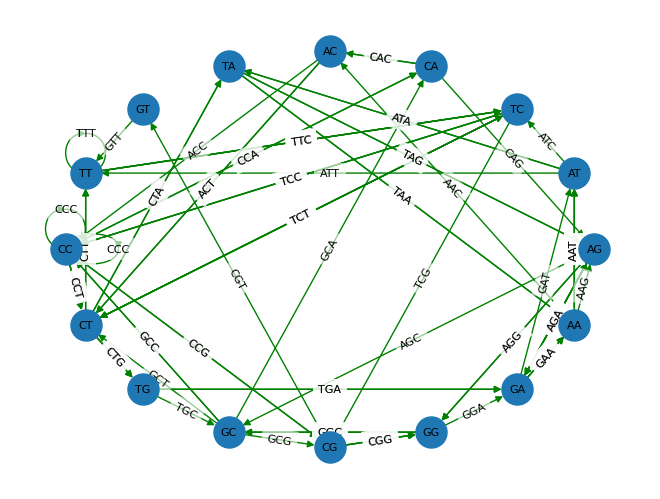

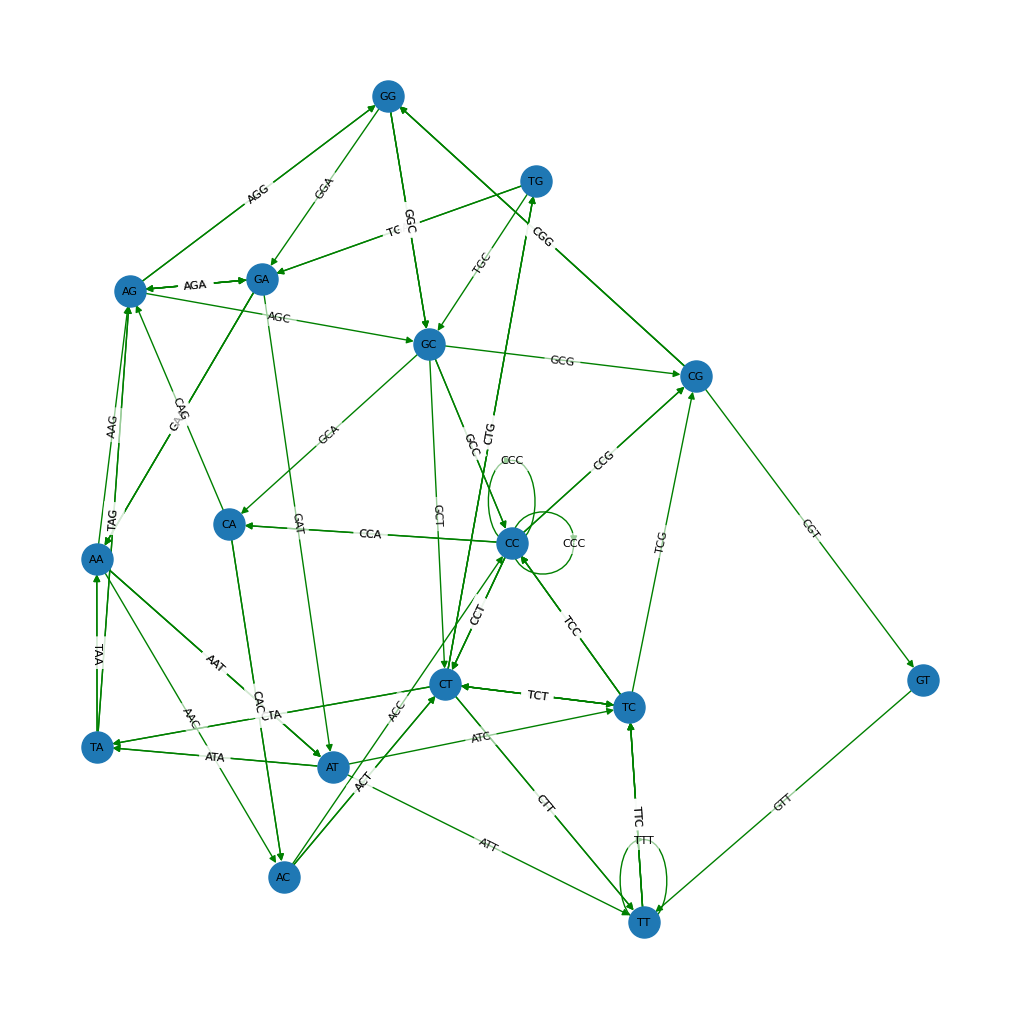

In [60]:
import networkx as nx
import matplotlib.pyplot as plt

class DeBruijnGraph:
    def __init__(self, sequences, k):
        """
        Inicializa la clase con una lista de secuencias y el valor de k para generar k-mers.
        """
        self.sequences = sequences
        self.k = k
        self.graph = self.construct_graph()

    def construct_graph(self):
        """
        Construye el grafo de De Bruijn a partir de las secuencias y el valor de k.
        """
        graph = nx.MultiDiGraph()  # Crear un grafo dirigido con múltiples aristas permitidas
        for seq in self.sequences:
            for i in range(len(seq) - self.k + 1):
                kmer = seq[i:i+self.k]  # Extraer el k-mer
                prefix, suffix = kmer[:-1], kmer[1:]  # Prefijo y sufijo del k-mer
                graph.add_edge(prefix, suffix, kmer=kmer)  # Añadir arista con k-mer como atributo
        return graph

    def visualize_graph(self, layout='kamada_kawai', edge_color="green"):
        """
        Visualiza el grafo de De Bruijn utilizando NetworkX y Matplotlib.
        """
        if layout == 'spring':
            pos = nx.spring_layout(self.graph)
        elif layout == 'shell':
            pos = nx.shell_layout(self.graph)
        elif layout == 'circular':
            pos = nx.circular_layout(self.graph)
        elif layout == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(self.graph)
        else:
            pos = nx.spring_layout(self.graph)

        edge_labels = nx.get_edge_attributes(self.graph, 'kmer')

        # Dibuja los nodos
        nx.draw(self.graph, pos, with_labels=True, node_size=500, font_size=8, edge_color=edge_color, arrows=True)

        # Dibuja las etiquetas de las aristas con k-mers y ajusta para mayor legibilidad
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_size=8,
                                     bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

        plt.show()

# Ejemplo de uso
sequences = ["CCTGCGGAAGATCGGCACTAGAATAGCCAGAACCGTTTCTCTGAGGCTTCCGGCCTTCCCTCCCACTAATAATTCTGAGG"]
k = 3
dbg = DeBruijnGraph(sequences, k)
#colocar layout
dbg.visualize_graph(layout='shell')
#permitir que el grafo se visualice mas grande y diferenciado entre nodos
plt.figure(figsize=(10, 10))
dbg.visualize_graph()   

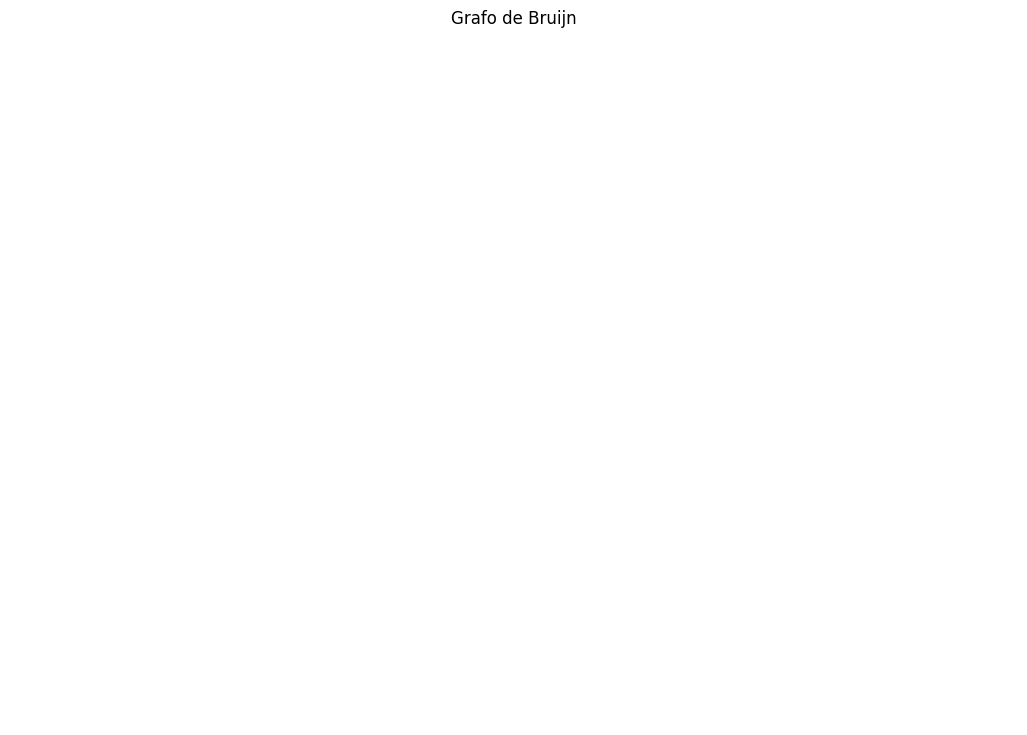

StopIteration: 

In [51]:
secuencia=["CCTGCGGAAGATCGGCACTAGAATAGCCAGAACCGTTTCTCTGAGGCTTCCGGCCTTCCCTCCCACTAATAATTCTGAGG"]
k=3

db = BruijnGrafo(secuencia, k)
db.draw_graph(layout='circular')
eulerian_path = db.find_eulerian_path()
print("Camino Euleriano:", eulerian_path)
# Encuentra el camino Euleriano
# 

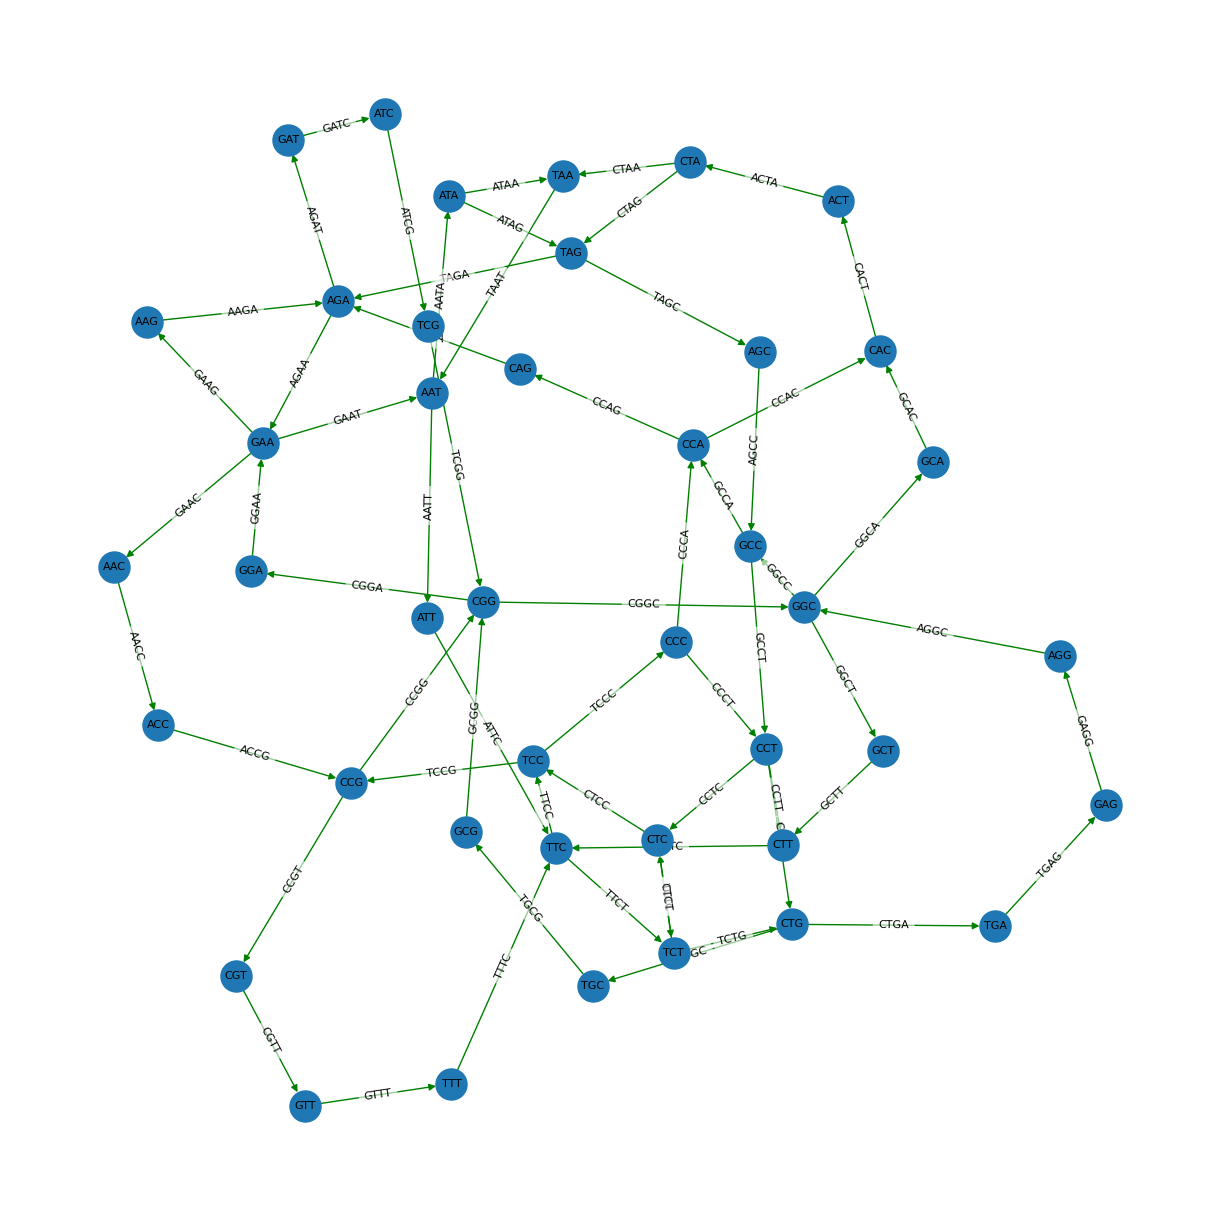

Exception: No es posible un camino Euleriano, nodos desequilibrados: ['GAA', 'AGA', 'GGC', 'CAC', 'CTA', 'ATA', 'TTC', 'CTT', 'CCC', 'TAA']

In [ ]:
secuencia=["CCTGCGGAAGATCGGCACTAGAATAGCCAGAACCGTTTCTCTGAGGCTTCCGGCCTTCCCTCCCACTAATAATTCTGAGG"]
k=4
graph = construct_de_bruijn_graph(secuencia, k)
plt.figure(figsize=(12, 12))
visualize_de_bruijn_graph(graph,layout="kamada_kawai")

eulerian_path = find_eulerian_path(graph)
print("Camino Euleriano:", eulerian_path)

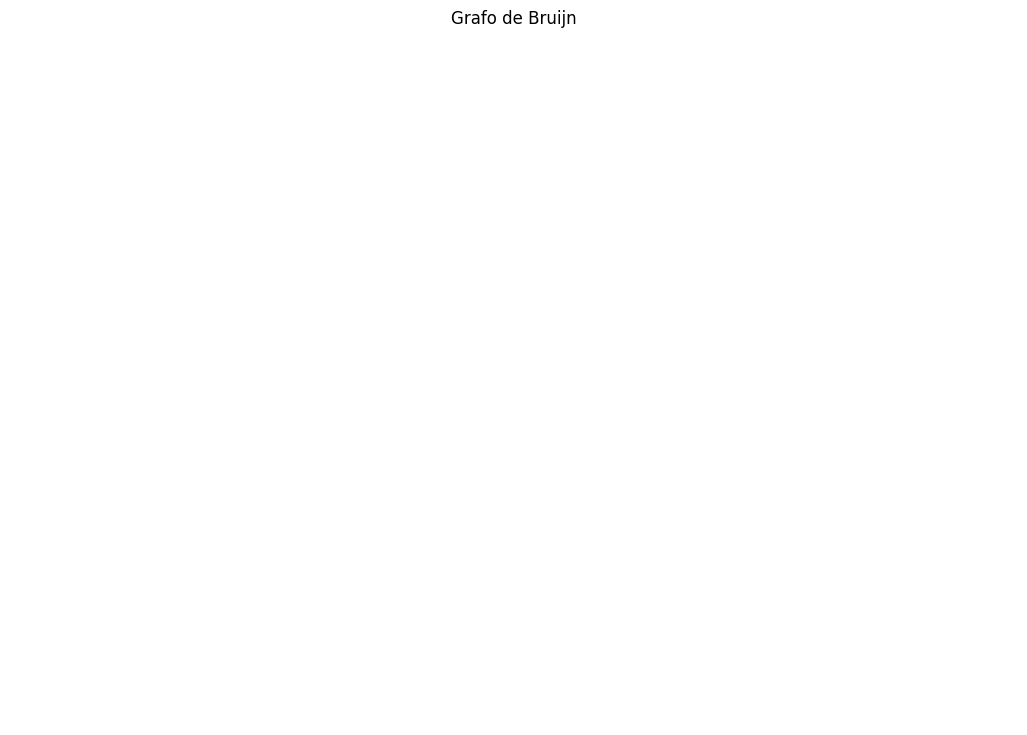

StopIteration: 

In [50]:
secuencia=["CCTGCGGAAGATCGGCACTAGAATAGCCAGAACCGTTTCTCTGAGGCTTCCGGCCTTCCCTCCCACTAATAATTCTGAGG"]
k=5
db = BruijnGrafo(secuencia, k)
db.draw_graph(layout='circular')
eulerian_path = db.find_eulerian_path()
print("Camino Euleriano:", eulerian_path)



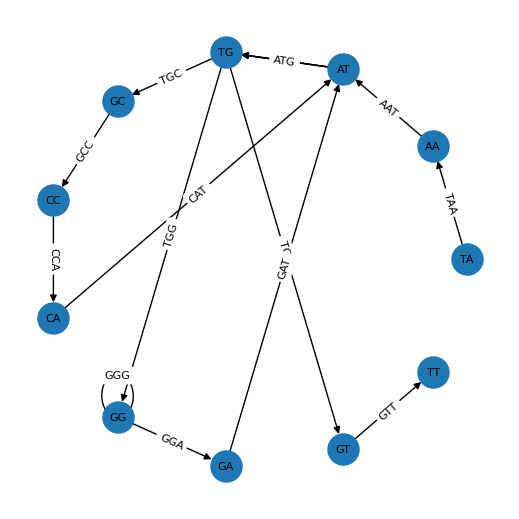

Camino Euleriano: TA->AA->AT->TG->GC->CC->CA->AT->TG->GG->GG->GA->AT->TG->GT->TT->TA


In [35]:
import networkx as nx
import matplotlib.pyplot as plt

class DeBruijnGraph:
    def __init__(self, sequence, k):
        """
        Inicializa la clase con la secuencia de ADN y el valor de k para generar k-mers.
        """
        self.sequence = sequence
        self.k = k
        self.kmers = self.generate_kmers()
        self.graph = self.construct_graph()
        self.inDeg = {}
        self.outDeg = {}
        self.unbalancedNode = []

    def generate_kmers(self):
        """
        Genera los k-mers a partir de la secuencia y los devuelve como una lista de cadenas.
        """
        kmers = []
        for i in range(len(self.sequence) - self.k + 1):
            kmer = self.sequence[i:i + self.k]  # Devuelve k-mers como cadenas
            kmers.append(kmer)
        return kmers

    def construct_graph(self):
        """
        Construye el grafo de De Bruijn a partir de los k-mers generados.
        Los nodos son los prefijos y sufijos de longitud k-1, 
        y las aristas están etiquetadas con los k-mers completos.
        """
        graph = nx.MultiDiGraph()  # Usamos un MultiDiGraph para permitir múltiples aristas entre nodos
        for kmer in self.kmers:
            prefix = kmer[:-1]  # Prefijo de longitud k-1
            suffix = kmer[1:]   # Sufijo de longitud k-1
            graph.add_edge(prefix, suffix, kmer=kmer)  # Añadimos la arista con la etiqueta k-mer
        return graph

    def visualize_graph(self, layout='spring'):
        """
        Visualiza el grafo de De Bruijn utilizando NetworkX y Matplotlib. 
        Las etiquetas de las aristas son los k-mers.
        """
        # Layout del grafo
        if layout == 'spring':
            pos = nx.spring_layout(self.graph)
        elif layout == 'shell':
            pos = nx.shell_layout(self.graph)
        elif layout == 'circular':
            pos = nx.circular_layout(self.graph)
        elif layout == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(self.graph)
        else:
            pos = nx.spring_layout(self.graph)
        
        # Dibujar nodos
        nx.draw(self.graph, pos, with_labels=True, node_size=500, font_size=8)
        
        # Etiquetas de las aristas (k-mers)
        edge_labels = nx.get_edge_attributes(self.graph, 'kmer')
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_size=8)

        plt.show()

    def addEdge(self):
        """
        Encuentra los nodos desequilibrados y balancea el grafo si es necesario añadiendo una arista.
        """
        for node in self.graph.nodes:
            self.inDeg[node] = self.graph.in_degree(node)
            self.outDeg[node] = self.graph.out_degree(node)
        
        for node in self.graph.nodes:
            if self.inDeg[node] != self.outDeg[node]:
                if self.outDeg[node] > self.inDeg[node]:
                    self.unbalancedNode.append(node)
                else:
                    self.unbalancedNode.insert(0, node)

        if len(self.unbalancedNode) > 0:
            self.graph.add_edge(self.unbalancedNode[0], self.unbalancedNode[1])
            self.outDeg[self.unbalancedNode[0]] += 1
            self.inDeg[self.unbalancedNode[1]] += 1

    def calculate_eulerian_path(self):
        """
        Calcula el camino Euleriano en el grafo utilizando el algoritmo de Hierholzer.
        """
        # Balanceamos el grafo si es necesario
        self.addEdge()
        
        # Realizamos la exploración
        path = []
        current_path = []
        graph_copy = self.graph.copy()
        
        # Elegimos un nodo inicial
        start_node = next(node for node in self.graph.nodes if self.graph.out_degree(node) > 0)
        current_path.append(start_node)
        
        while current_path:
            current_node = current_path[-1]
            if graph_copy.out_degree(current_node) > 0:
                next_node = next(graph_copy.successors(current_node))
                current_path.append(next_node)
                graph_copy.remove_edge(current_node, next_node)
            else:
                path.append(current_path.pop())
        
        # Si el grafo fue balanceado con una arista adicional, ajustar el camino
        if len(self.unbalancedNode) > 0:
            for i in range(len(path)-1):
                if path[i] == self.unbalancedNode[0] and path[i+1] == self.unbalancedNode[1]:
                    path = path[i+1:] + path[:i+1]
                    break
        
        return '->'.join(path[::-1])  # Devolvemos el camino como una cadena

# Ejemplo de uso:
sequence = "TAATGCCATGGGATGTT"
k = 3

# Crear instancia de la clase DeBruijnGraph
db_graph = DeBruijnGraph(sequence, k)

# Visualizar el grafo más ampliado entre nodos
plt.figure(figsize=(5,5))
# Visualizar el grafo
db_graph.visualize_graph(layout="circular")

# Calcular el camino Euleriano
eulerian_path = db_graph.calculate_eulerian_path()
print("Camino Euleriano:", eulerian_path)


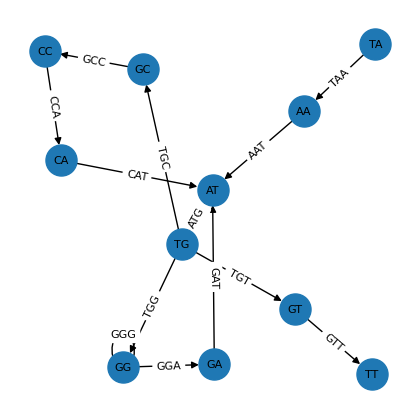

Camino Euleriano: TA->AA->AT->TG->GT->TT->AT->GG->GG->GA->AT->GC->CC->CA->AT


In [28]:
# Ejemplo de uso:
sequence = "TAATGCCATGGGATGTT"
k = 3

# Crear instancia de la clase DeBruijnGraph
db_graph = DeBruijnGraph(sequence, k)

# Visualizar el grafo mas ampliado entre nodos
plt.figure(figsize=(4, 4))
# Visualizar el grafo
db_graph.visualize_graph(layout="kamada_kawai")

# Calcular el camino Euleriano
eulerian_path = db_graph.calculate_eulerian_path()
print("Camino Euleriano:", eulerian_path)

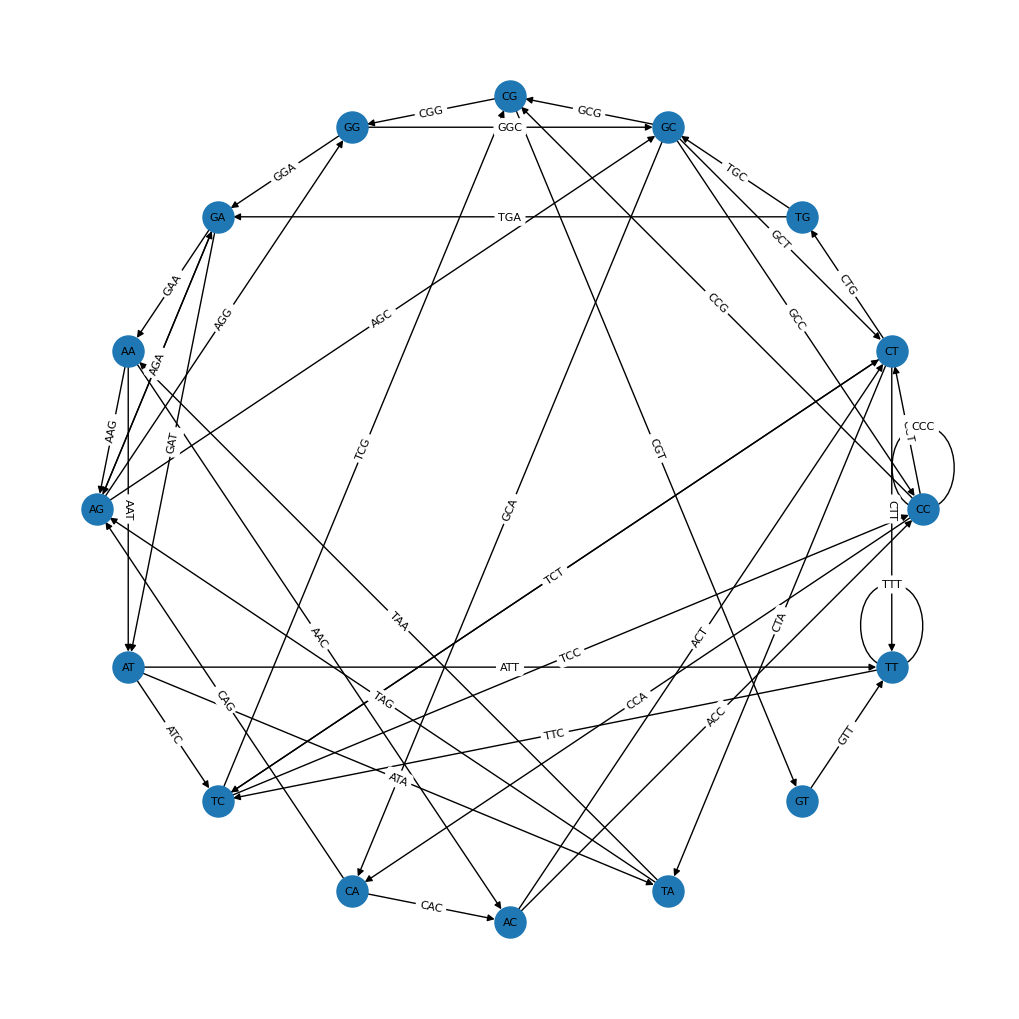

Camino Euleriano: CC->CT->TG->GA->GC->CG->GG->GA->AA->AG->GA->AG->AT->TC->CG->GT->TT->TT->TC->CT->TA->AA->AC->AT->TT->TA->AG->GC->CA->AC->CC->CT->TC->CC->CA->AG->GG->GC->CT->TT->AG->CC->CC->CG


In [16]:
secuencia="CCTGCGGAAGATCGGCACTAGAATAGCCAGAACCGTTTCTCTGAGGCTTCCGGCCTTCCCTCCCACTAATAATTCTGAGG"
k=3
# Crear instancia de la clase DeBruijnGraph
db_graph = DeBruijnGraph(secuencia, k)

# Visualizar el grafo mas ampliado entre nodos
plt.figure(figsize=(10, 10))
# Visualizar el grafo
db_graph.visualize_graph(layout="circular")

# Calcular el camino Euleriano
eulerian_path = db_graph.calculate_eulerian_path()
print("Camino Euleriano:", eulerian_path)


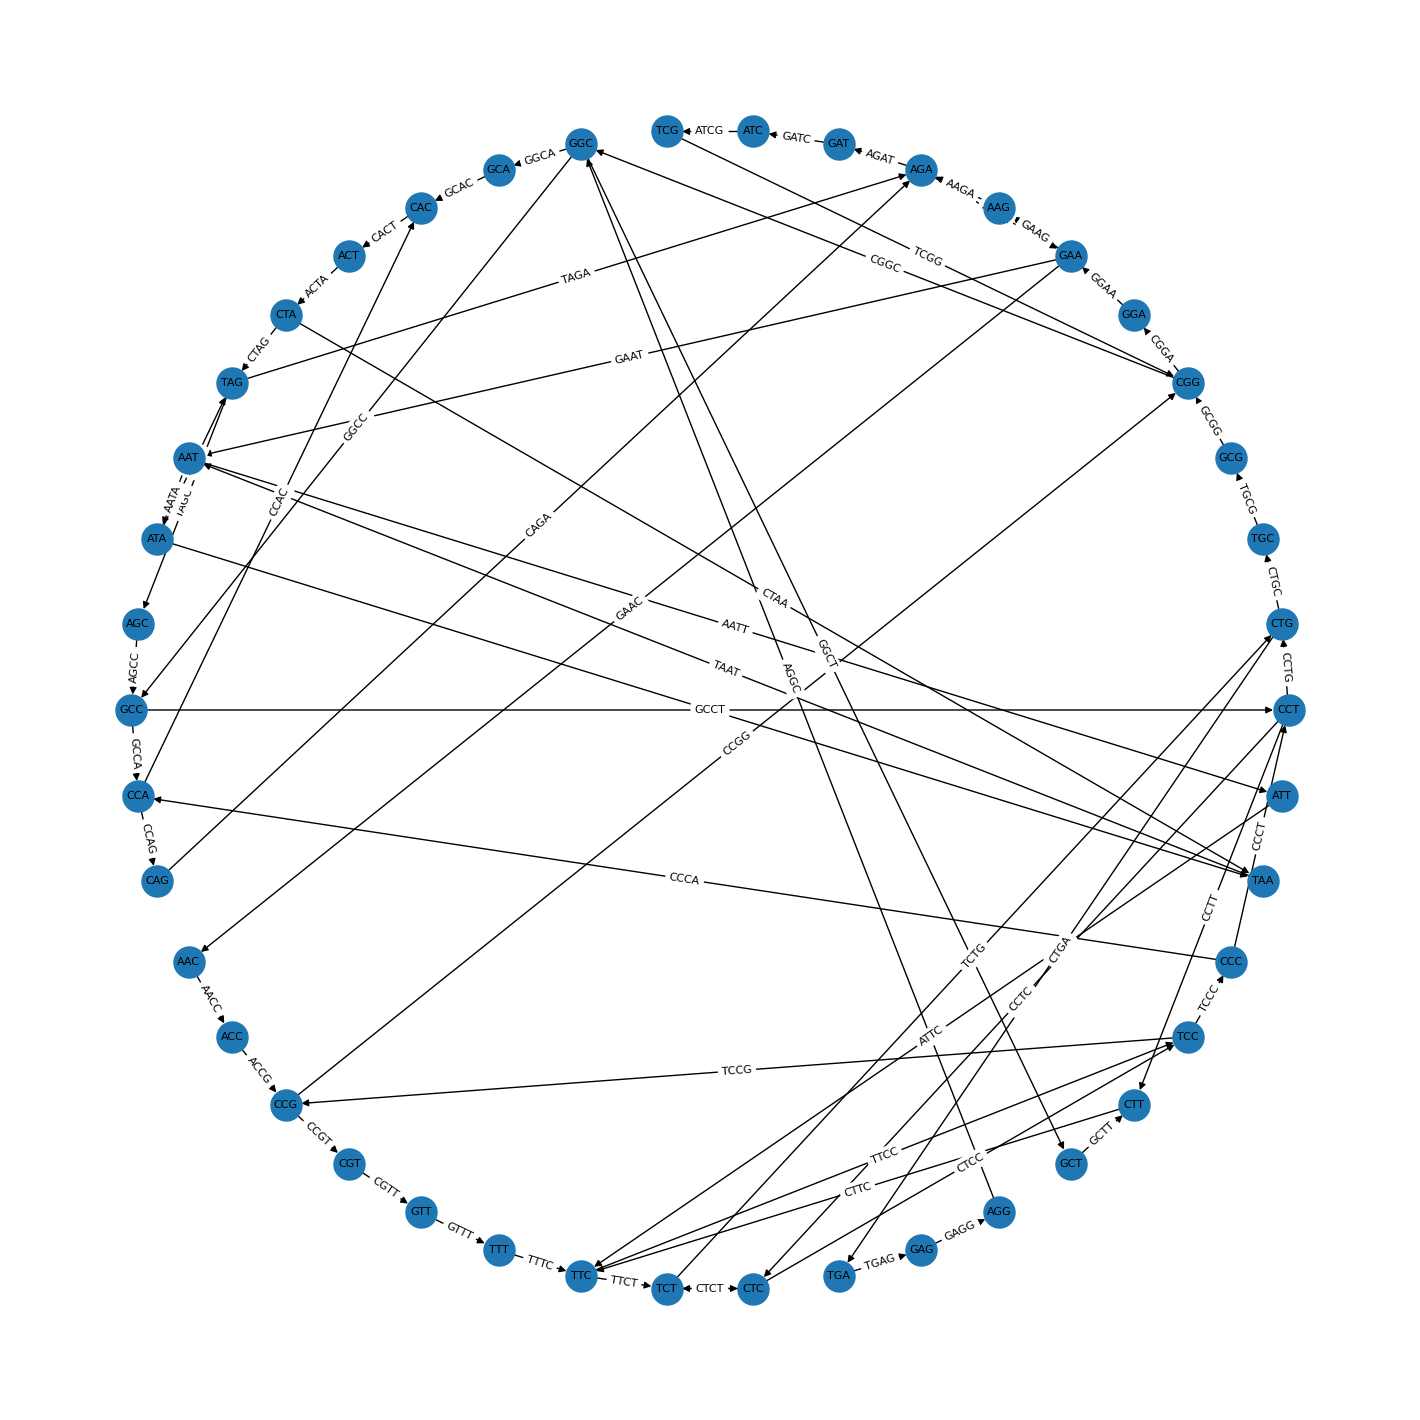

Camino Euleriano: CCT->CTG->TGC->GCG->CGG->GGA->GAA->AAG->AGA->GAT->ATC->TCG->CGG->GGC->GCA->CAC->ACT->CTA->TAA->TAG->AGA->GAA->AAC->ACC->CCG->AAT->ATA->TAA->CTT->AAT->ATT->TTC->TAG->AGC->GCC->CCT->CTT->TTC->TCT->CTC->TCC->CCG->CGG->CGT->GTT->TTT->TTC->TCC->CCC->CCA->CCT->CTC->TCT->CTG->TGA->GAG->AGG->GGC->GCC->GCT->CTT->CCA->CAC->CAG->AGA


In [18]:
secuencia="CCTGCGGAAGATCGGCACTAGAATAGCCAGAACCGTTTCTCTGAGGCTTCCGGCCTTCCCTCCCACTAATAATTCTGAGG"
k=4
# Crear instancia de la clase DeBruijnGraph
db_graph = DeBruijnGraph(secuencia, k)

# Visualizar el grafo mas ampliado entre nodos
plt.figure(figsize=(14, 14))
# Visualizar el grafo
db_graph.visualize_graph(layout="circular")

# Calcular el camino Euleriano
eulerian_path = db_graph.calculate_eulerian_path()
print("Camino Euleriano:", eulerian_path)


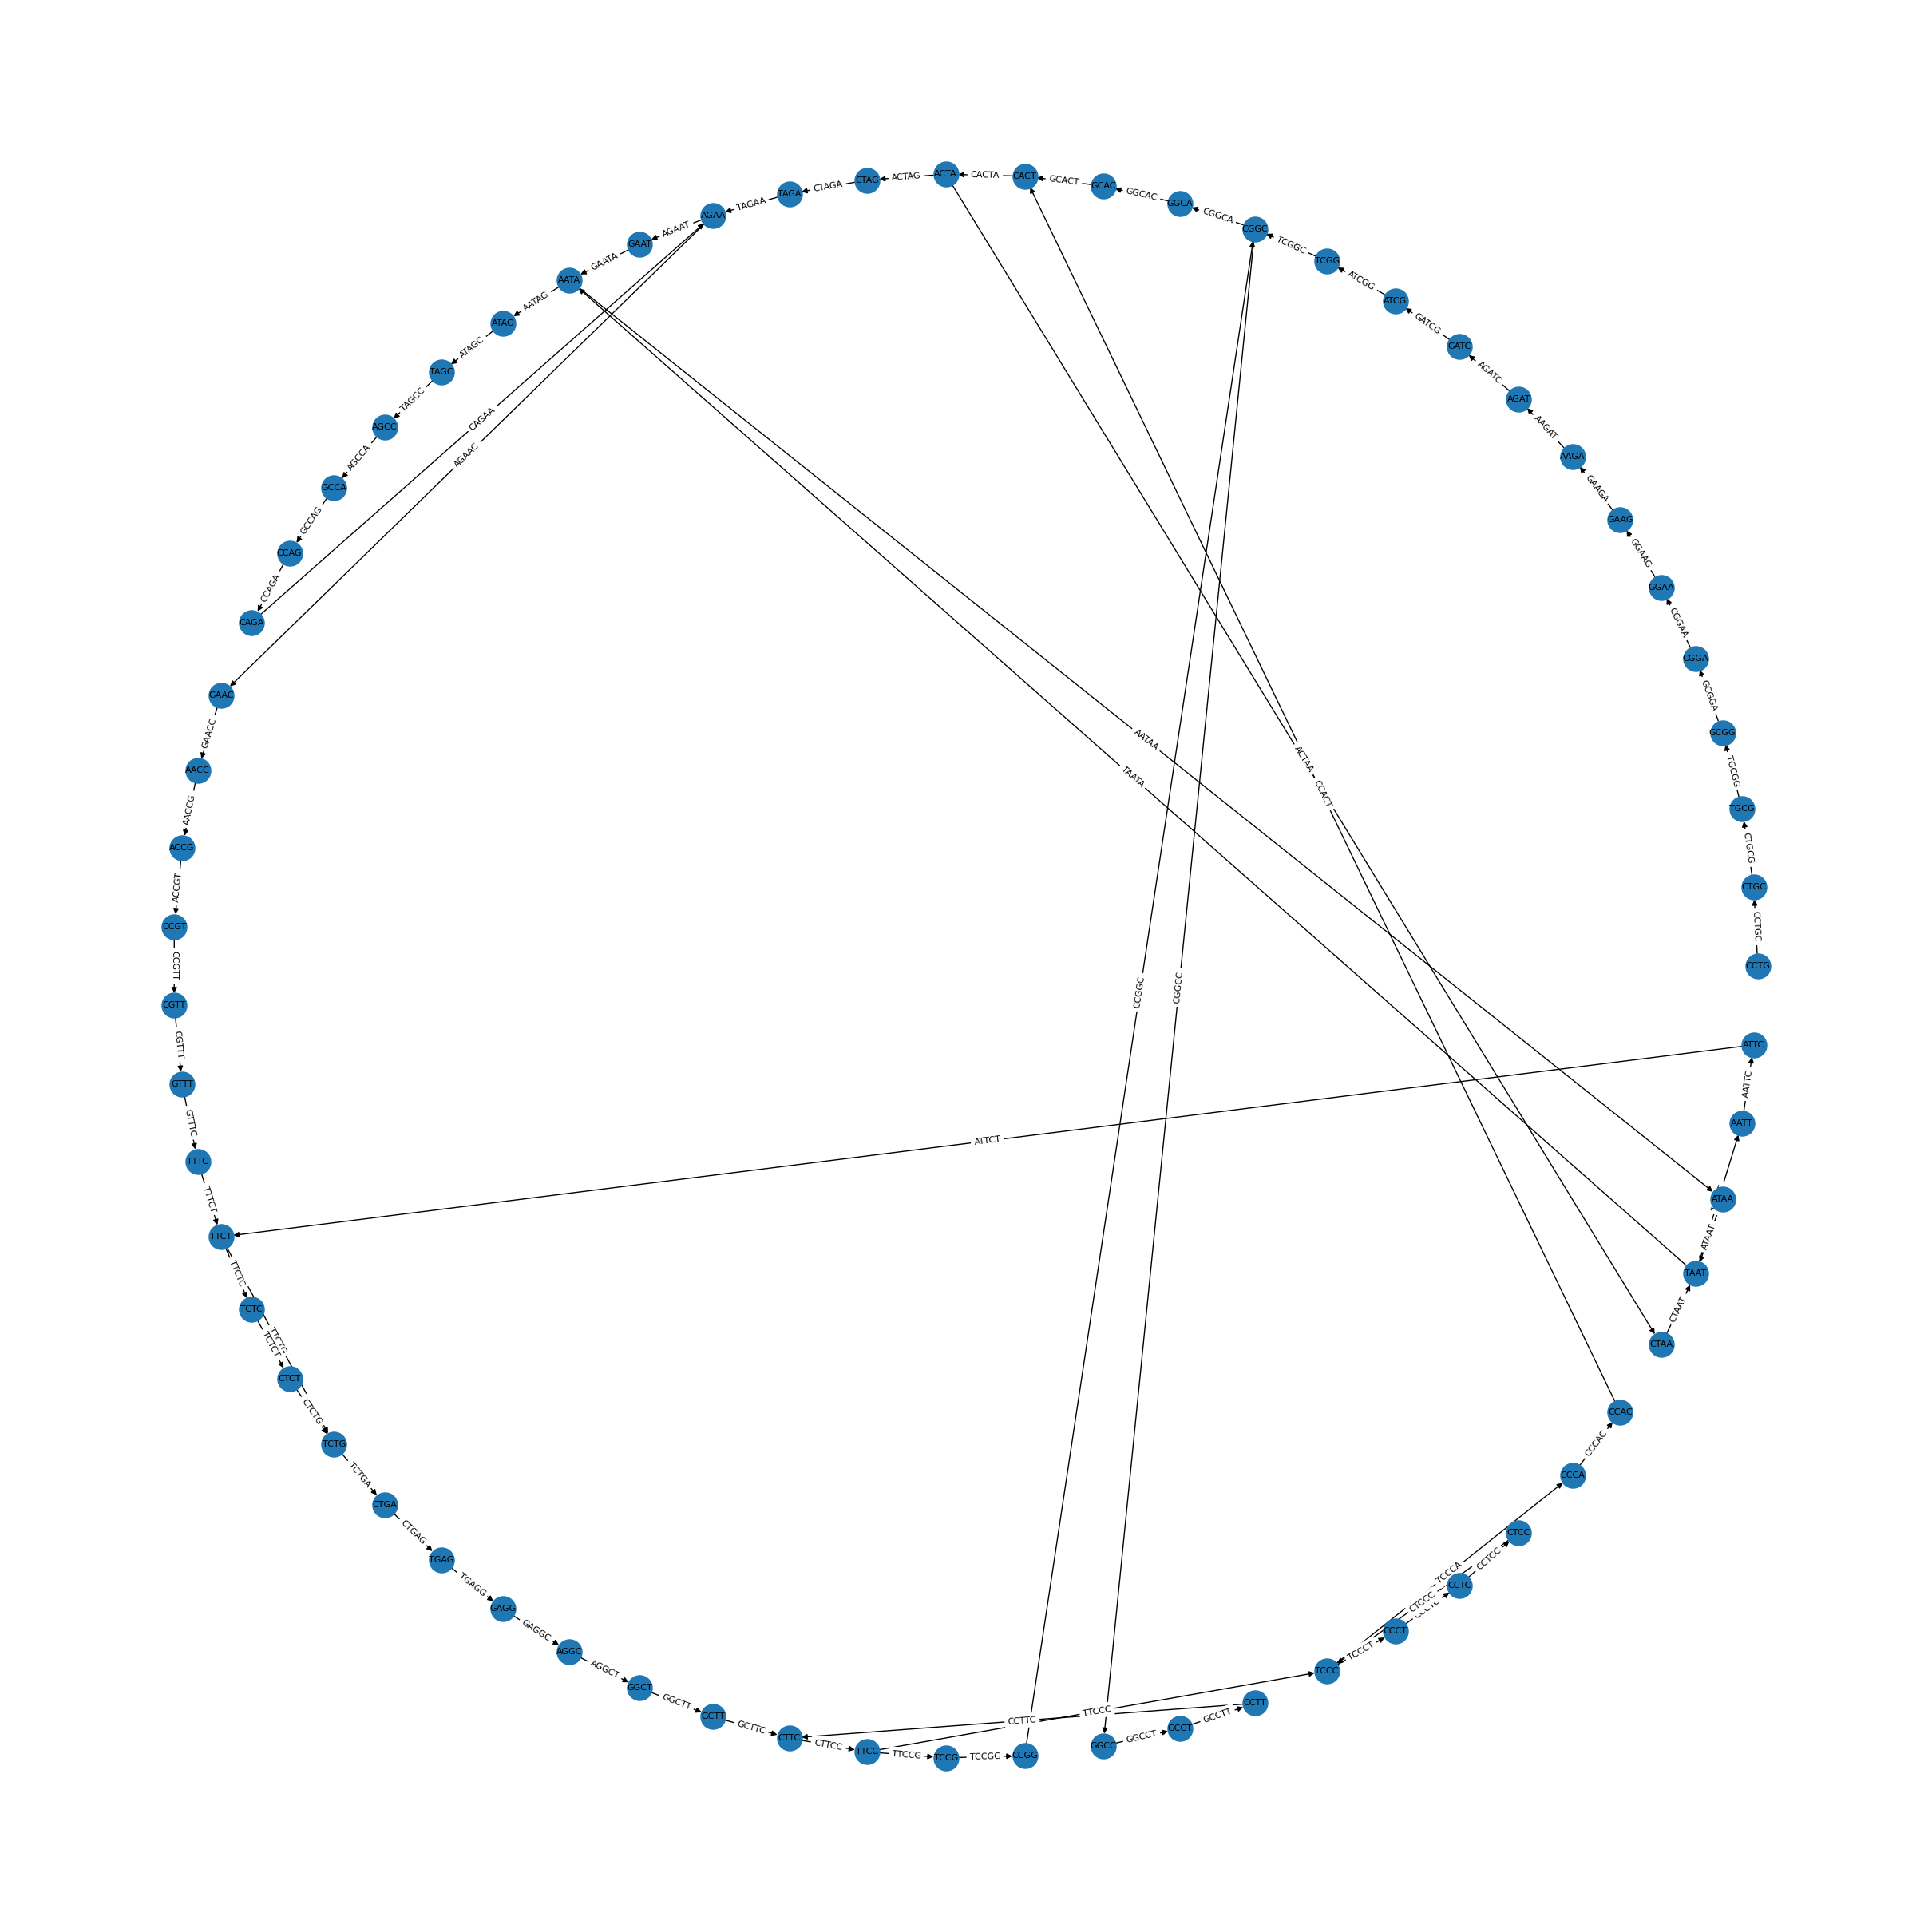

Camino Euleriano: CCTG->CTGC->TGCG->GCGG->CGGA->GGAA->GAAG->AAGA->AGAT->GATC->ATCG->TCGG->CGGC->GGCA->GCAC->CACT->ACTA->CTAA->TAAT->CTAG->TAGA->AGAA->GAAT->AATA->ATAA->TAAT->AATT->ATTC->TTCT->AATA->ATAG->TAGC->AGCC->GCCA->CCAG->CAGA->AGAA->GAAC->AACC->ACCG->CCGT->CGTT->GTTT->TTTC->TTCT->TCTG->TCTC->CTCT->TCTG->CTGA->TGAG->GAGG->AGGC->GGCT->GCTT->CTTC->TTCC->TCCC->CCCT->CCTC->CTCC->TCCC->CCCA->CCAC->CACT->TCCG->CCGG->CGGC->GGCC->GCCT->CCTT->CTTC->TCTG


In [26]:
secuencia="CCTGCGGAAGATCGGCACTAGAATAGCCAGAACCGTTTCTCTGAGGCTTCCGGCCTTCCCTCCCACTAATAATTCTGAGG"
k=5
# Crear instancia de la clase DeBruijnGraph
db_graph = DeBruijnGraph(secuencia, k)

# Visualizar el grafo mas ampliado entre nodos
plt.figure(figsize=(24, 24))
# Visualizar el grafo
db_graph.visualize_graph(layout="circular")

# Calcular el camino Euleriano
eulerian_path = db_graph.calculate_eulerian_path()
print("Camino Euleriano:", eulerian_path)


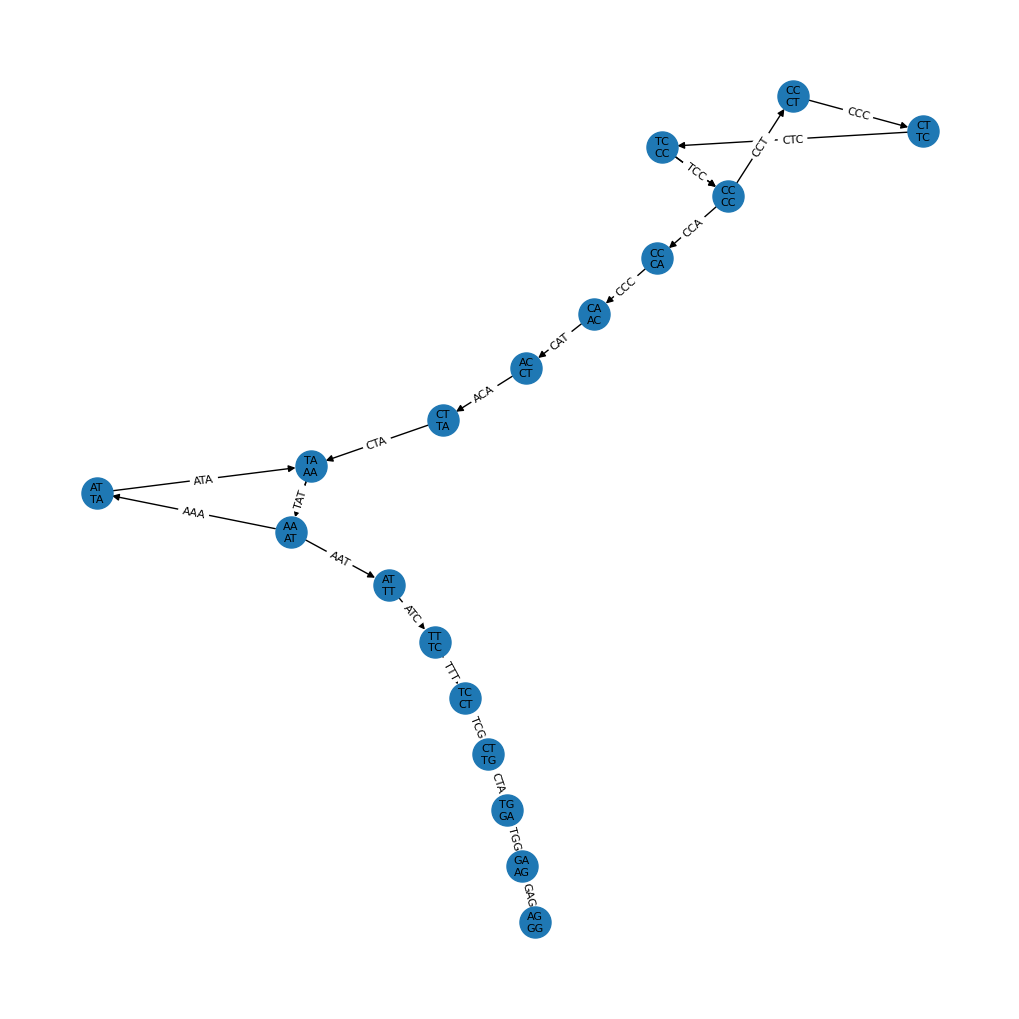

Camino Euleriano: TCC->CCC->CCT->CTC->TCC->CCC->CCA->CAC->ACT->CTA->TAA->AAT->ATA->TAA->AAT->ATT->TTC->TCT->CTG->TGA->GAG->AGG


In [44]:
import networkx as nx
import matplotlib.pyplot as plt

class DeBruijnGraphTuples:
    def __init__(self, sequence, k):
        """
        Inicializa la clase con la secuencia de ADN y el valor de k para generar las tuplas de k-mers.
        """
        self.sequence = sequence
        self.k = k
        self.tuples = self.generate_tuples()
        self.graph = self.construct_graph()
        self.inDeg = {}
        self.outDeg = {}
        self.unbalancedNode = []

    def generate_tuples(self):
        """
        Genera las tuplas de tamaño k-1 a partir de la secuencia.
        Por ejemplo, para k=3, devuelve tuplas de tamaño 2.
        """
        tuples = []
        for i in range(len(self.sequence) - self.k + 1):
            tuple_kmer = [self.sequence[i:i + 2], self.sequence[i + 1:i + 3]]
            tuples.append(tuple(tuple_kmer))
        return tuples

    def construct_graph(self):
        """
        Construye el grafo de De Bruijn a partir de las tuplas generadas.
        Los nodos son las tuplas, y las aristas conectan las tuplas consecutivas.
        """
        graph = nx.MultiDiGraph()  # Usamos un MultiDiGraph para permitir múltiples aristas entre nodos
        for i in range(len(self.tuples) - 1):
            prefix = self.tuples[i]  # Nodo origen
            suffix = self.tuples[i + 1]  # Nodo destino
            label = prefix[0] + suffix[1][-1]  # Etiqueta de arista, como la cadena completa formada entre los nodos
            graph.add_edge(prefix, suffix, label=label)  # Añadimos la arista con la secuencia formada
        return graph

    def visualize_graph(self, layout='spring'):
        """
        Visualiza el grafo de De Bruijn utilizando NetworkX y Matplotlib.
        Visualiza los nodos y las aristas con las secuencias correspondientes.
        """
        # Layout del grafo
        if layout == 'spring':
            pos = nx.spring_layout(self.graph)
        elif layout == 'shell':
            pos = nx.shell_layout(self.graph)
        elif layout == 'circular':
            pos = nx.circular_layout(self.graph)
        elif layout == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(self.graph)
        else:
            pos = nx.spring_layout(self.graph)
        
        # Convertir nodos a cadenas concatenando la tupla para visualización
        node_labels = {node: f'{node[0]}\n{node[1]}' for node in self.graph.nodes()}
        
        # Dibujar nodos
        nx.draw(self.graph, pos, labels=node_labels, node_size=500, font_size=8, with_labels=True)
        
        # Etiquetas de las aristas (cadenas formadas entre nodos)
        edge_labels = nx.get_edge_attributes(self.graph, 'label')
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_size=8)

        plt.show()

    def calculate_eulerian_path(self):
        """
        Calcula el camino Euleriano en el grafo utilizando el algoritmo de Hierholzer.
        """
        # Realizamos la exploración
        path = []
        current_path = []
        graph_copy = self.graph.copy()
        
        # Elegimos un nodo inicial
        start_node = next(node for node in self.graph.nodes if self.graph.out_degree(node) > 0)
        current_path.append(start_node)
        
        while current_path:
            current_node = current_path[-1]
            if graph_copy.out_degree(current_node) > 0:
                next_node = next(graph_copy.successors(current_node))
                current_path.append(next_node)
                graph_copy.remove_edge(current_node, next_node)
            else:
                path.append(current_path.pop())
        
        return '->'.join([f'{node[0]}{node[1][-1]}' for node in path[::-1]])  # Devolvemos el camino como una cadena

# Ejemplo de uso:
sequence = "TCCCTCCCACTAATAATTCTGAGG"
k = 3

# Crear instancia de la clase DeBruijnGraphTuples
db_graph_tuples = DeBruijnGraphTuples(sequence, k)

# Visualizar el grafo más ampliado entre nodos
plt.figure(figsize=(10,10))
# Visualizar el grafo
db_graph_tuples.visualize_graph(layout="kamada_kawai")

# Calcular el camino Euleriano
eulerian_path = db_graph_tuples.calculate_eulerian_path()
print("Camino Euleriano:", eulerian_path)
